In [3]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
np.random.seed(131533)

## Task 1: Acquire MNIST data


In [4]:
from keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
train_images = x_train
test_images = x_test
train_labels = y_train
test_labels = y_test
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

Flatten the images for input to the MLP, center and normalize the training and test set

In [5]:
x_train = x_train.reshape(60000, 28**2)
x_unormalized = np.array(x_train.copy(), dtype=np.float128)
x_test = x_test.reshape(10000, 28**2)
x_unormalized_test = np.array(x_test.copy(), dtype=np.float128)

x_train = x_train - np.mean(x_train, axis = 0)
x_train = np.array(x_train / np.std(x_train, axis = 0), dtype=np.float128)

x_test = x_test - np.mean(x_test, axis = 0)
x_test = np.array(x_test / np.std(x_test, axis = 0), dtype=np.float128)

y_train = np.array(np.eye(10)[np.array(y_train)], dtype=np.float128)
y_test =  np.array(np.eye(10)[np.array(y_test)], dtype=np.float128)

In [6]:
np.max(x_train[142,:])

2.22092773805869248

#Task 2: Implement MLP

Multilayer perceptron

In [7]:
class NeuralNetLayer:
  def __init__(self):
    self.gradient = None
    self.parameters = None
      
  def forward(self, x, val=False):
    raise NotImplementedError

  def backward(self, gradient):
    raise NotImplementedError

In [8]:
class LinearLayer(NeuralNetLayer):
  def __init__(self, input_size, output_size, l2_reg=0):
    super().__init__()
    self.ni = input_size
    self.no = output_size
    self.w = np.random.randn(output_size, input_size) * np.sqrt(2/(input_size + output_size))
    self.b = np.random.randn(output_size) * np.sqrt(2/(input_size + output_size))
    self.cur_input = None
    self.parameters = [self.w, self.b]
    self.l2_reg = l2_reg

  def forward(self, x, val=False):
    if val == False:
      self.cur_input = x
    return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

  def backward(self, gradient, check=False):
    assert self.cur_input is not None, "Must call forward before backward"
    dw = gradient[:, :, None] @ self.cur_input[:, None, :]
    db = gradient
    self.gradient = [dw + (self.l2_reg * self.w), db + (self.l2_reg * self.b)]
    return gradient.dot(self.w)

In [9]:
class ReLU(NeuralNetLayer):
  def __init__(self):
    super().__init__()
      
  def forward(self, x, val=False):
    if val == False:
      self.gradient = np.where(x > 0, 1.0, 0.0)
    return np.maximum(0, x)

  def backward(self, gradient):
    assert self.gradient is not None, "Must call forward before backward"
    return gradient * self.gradient

In [10]:
class SoftmaxOutputLayer(NeuralNetLayer):
  def __init__(self):
      super().__init__()
      self.cur_probs = None

  def forward(self, x, val=False):
    x = x - np.amax(x)
    exps = np.exp(x)
    probs = exps / np.sum(exps, axis=-1)[:, None]
    if val == False:
      self.cur_probs = probs
    return probs

  def backward(self, target):
    assert self.cur_probs is not None, "Must call forward before backward"
    return self.cur_probs - target

In [11]:
class LeakyReLU(NeuralNetLayer):
  def __init__(self):
    super().__init__()

  def forward(self, x, val=False):
    if val == False:
      self.gradient = np.where(x > 0, 1.0, 0.01)                                      
    return np.where(x > 0, x, x * 0.01) 
  
  def backward(self, gradient):
    assert self.gradient is not None, "Must call forward before backward"
    return gradient * self.gradient 

In [12]:
class TanH(NeuralNetLayer):
  def __init__(self):
    super().__init__()

  def forward(self, x, val=False):
    if val == False:
      self.gradient = 1.-np.tanh(x)**2 
    return np.tanh(x)
  
  def backward(self, gradient):
    assert self.gradient is not None, "Must call forward before backward"
    return gradient * self.gradient 

In [13]:
import math
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

Accuracy Evaluation

In [14]:
def evaluate_acc(y_true, y_pred):
  total_n = len(y_true)
  return np.sum(y_true == y_pred) / total_n

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
class MLP(BaseEstimator):
  def __init__(self, layer_size=None, activation=None, batch_size=2, lr=1e-1, iter=1, patience=10, l2_reg=0):
    self.layers = None
    self.batch_size = batch_size
    self.iter = iter
    self.lr = lr
    self.activation = activation
    self.layer_size = layer_size
    self.patience = patience
    self.l2_reg = l2_reg

    if self.layer_size is not None and len(self.layer_size) > 0:
      self.layers = [LinearLayer(784, layer_size[0], self.l2_reg)]
      if self.activation is not None:
        self.layers.append(self.activation())

      for i in range(1, len(self.layer_size)):
        self.layers.append(LinearLayer(self.layer_size[i-1], self.layer_size[i], self.l2_reg))
        if self.activation is not None:
          self.layers.append(self.activation())
      
      self.layers.append(LinearLayer(self.layer_size[-1], 10, self.l2_reg))
      self.layers.append(SoftmaxOutputLayer())
    
    else:
      self.layers = [LinearLayer(784, 10)]
      self.layers.append(SoftmaxOutputLayer())


  def fit(self, x, y, val=False, ce_plot=False, acc_plot=False):
    if self.layers is not None:
      time = 0
      done = False
      losses = []
      losses_val = []
      prev = math.inf
      epochs = 0
      if val == True:
        x, x_val, y, y_val = train_test_split(x, y, test_size=0.5, train_size=0.5, random_state=42)
        indicies_val = np.random.permutation(x_val.shape[0])
        targets_val = y_val[indicies_val, :]
        x_val = x_val[indicies_val, :]
      indicies = np.random.permutation(x.shape[0])
      x = x[indicies, :]
      targets = y[indicies, :]
      acc_train = []
      acc_val = []
      for _ in range(self.iter):
        if done == True:
          break
        for i in range(0, x.shape[0]-self.batch_size, self.batch_size):
          pred = x[i:i+self.batch_size,:]
          labels = targets[i:i+self.batch_size,:]
          if val == True:
            pred_val = x_val[i:i+self.batch_size,:]
            labels_val = targets_val[i:i+self.batch_size,:]
          for layer in self.layers:
            pred = layer.forward(pred)
            if val == True:
              pred_val = layer.forward(pred_val, val=True)
          if i == 0:
            acc_train.append(evaluate_acc(labels.argmax(axis=1), pred.argmax(axis=1)))
            if val == True:
              acc_val.append(evaluate_acc(labels_val.argmax(axis=1), pred_val.argmax(axis=1)))
          loss = -(labels * np.log(pred)).sum(axis=-1).mean()
          if val == True:
            loss_val = -(labels_val * np.log(pred_val)).sum(axis=-1).mean()
            if (loss_val < prev):
              time = 0
            else:
              time += 1
              if time >= self.patience:
                done = True
                break
            losses_val.append(loss_val)
            prev = loss_val

          losses.append(loss)
          #print(f"loss: {loss}")
          #print(f"loss_val: {loss_val}")
          for layer in self.layers[::-1]:
            labels = layer.backward(labels)

          for layer in self.layers[::-1]:
            if layer.parameters is not None:
              for (p, g) in zip(layer.parameters, layer.gradient):
                p -= self.lr * g.mean(axis=0)
          
          epochs += 1
      
      # print(f"epochs: {epochs}")
      if ce_plot:
        plt.clf()
        plt.plot(losses, label="loss_train")
        if val == True:
          plt.plot(losses_val, label="loss_validation")
        plt.xlabel("Iterations")
        plt.ylabel("Cross entropy loss")
        plt.legend()
        plt.show()
      
      if acc_plot:
        self.best_iter = np.argmax(acc_val)
        plt.clf()
        plt.plot(acc_train, label="Training Accuracy")
        if val == True:
          plt.plot(acc_val, label="Validation Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()


    # else:
    #   self.model = MulticlassRegression(784, 10, self.lr, 1e-4, self.iter)
    #   self.model.fit(x, y)

      
  def predict(self, x):
    if self.layers is not None:
      pred = x
      for layer in self.layers:
        pred = layer.forward(pred)

      #print(f"predictions: {pred}")
      return pred
    else:
      return self.model.predict(x)
  
  def score(self, x, y):
    y_pred = self.predict(x)
    return evaluate_acc(y.argmax(axis=1), y_pred.argmax(axis=1))

  def ce(self, X, y, y_hat):
    return -np.nansum(y * np.log(y_hat))

  def check_g(self, x, y):
    ret = []
    pred = x
    labels = y
    for layer in self.layers:
      pred = layer.forward(pred)
    
    for layer in self.layers[::-1]:
      if layer.parameters is not None:
        #print(f"label shape: {labels.shape}")
        C = y.shape[1]
        D = x.shape[1]
        diff = np.zeros((C, D))
        w = np.array(layer.w.copy(), dtype=np.float128)
        input = layer.cur_input
        for i in range(C):
          for j in range(D):
            epsilon = np.zeros((C, D))
            epsilon[i, j] = np.random.rand() * 1e-5
            layer.w = layer.w + epsilon
            ce1 = -np.nansum(y * np.log(self.predict(x)))
           # print(f"ce1: {ce1}")
            #ce1 = (y * np.log(self.predict(x))).sum(axis=-1).mean()
            layer.w = w

            layer.w = layer.w - epsilon
            ce2 = -np.nansum(y * np.log(self.predict(x)))
           # print(f"ce2: {ce2}")
            #ce2 = (y * np.log(self.predict(x))).sum(axis=-1).mean()
            layer.w = w
            
            numeric_g = (ce1 - ce2) / (2*epsilon[i, j])
            #print(f"gradient before: {layer.gradient[0].mean(axis=0)[i,j]} ")
            layer.cur_input = input
            layer.backward(labels)
            #print(f"gradient after: {layer.gradient[0].mean(axis=0)[i,j]} ")
            derived_g = layer.gradient[0].mean(axis=0)[i,j]*x.shape[0]

            # print(f"numeric: {numeric_g}")
            # print(f"derived: {derived_g}")
            
            diff[i, j] = np.square(derived_g - numeric_g).sum() / \
                      np.square(derived_g + numeric_g).sum()
            
        ret.append(diff.sum())
      
      labels = layer.backward(labels)
    
    return ret
    


#Task 3: Experiments

##Experiment #1

In [ ]:
from sklearn.model_selection import GridSearchCV
from scipy.optimize import check_grad
parameter_space = {
    'lr': [1e-1, 5e-2, 1e-2, 5e-3]
}
X_training, X_testing, y_training, y_testing = train_test_split(x_train, y_train, train_size=0.16666, random_state=42)

NameError: ignored

In [ ]:
mlp0 = MLP(activation=ReLU, patience=10, batch_size=128)
mlp0 = GridSearchCV(mlp0, parameter_space, n_jobs=-1, cv=2)
mlp0.fit(x_train, y_train)

print('Best parameters found:\n', mlp0.best_params_)

mlp0_means = mlp0.cv_results_['mean_test_score']
mlp0_stds = mlp0.cv_results_['std_test_score']
for mean, std, params in zip(mlp0_means, mlp0_stds, mlp0.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

mlp0_pred = mlp0.predict(x_test)
evaluate_acc(y_test.argmax(axis=1), mlp0_pred.argmax(axis=1))

Best parameters found:
 {'lr': 0.1}
0.829 (+/-0.001) for {'lr': 0.1}
0.825 (+/-0.005) for {'lr': 0.05}
0.783 (+/-0.004) for {'lr': 0.01}
0.747 (+/-0.019) for {'lr': 0.005}


0.8074

In [ ]:
mlp1 = MLP([128], activation=ReLU, patience=10, batch_size=128)
mlp1 = GridSearchCV(mlp1, parameter_space, n_jobs=-1, cv=2)
mlp1.fit(x_train, y_train)

print('Best parameters found:\n', mlp1.best_params_)

mlp1_means = mlp1.cv_results_['mean_test_score']
mlp1_stds = mlp1.cv_results_['std_test_score']
for mean, std, params in zip(mlp1_means, mlp1_stds, mlp1.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

mlp1_pred = mlp1.predict(x_test)
evaluate_acc(y_test.argmax(axis=1), mlp1_pred.argmax(axis=1))

Best parameters found:
 {'lr': 0.1}
0.843 (+/-0.007) for {'lr': 0.1}
0.835 (+/-0.000) for {'lr': 0.05}
0.793 (+/-0.001) for {'lr': 0.01}
0.756 (+/-0.008) for {'lr': 0.005}


0.8505

In [ ]:
mlp2 = MLP([128, 128], activation=ReLU, patience=10, batch_size=128)
mlp2 = GridSearchCV(mlp2, parameter_space, n_jobs=-1, cv=2)
mlp2.fit(x_train, y_train)

print('Best parameters found:\n', mlp2.best_params_)

mlp2_means = mlp2.cv_results_['mean_test_score']
mlp2_stds = mlp2.cv_results_['std_test_score']
for mean, std, params in zip(mlp2_means, mlp2_stds, mlp2.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
  
mlp2_pred = mlp2.predict(x_test)
evaluate_acc(y_test.argmax(axis=1), mlp2_pred.argmax(axis=1))

Best parameters found:
 {'lr': 0.1}
0.841 (+/-0.007) for {'lr': 0.1}
0.838 (+/-0.004) for {'lr': 0.05}
0.777 (+/-0.000) for {'lr': 0.01}
0.736 (+/-0.013) for {'lr': 0.005}


0.8511

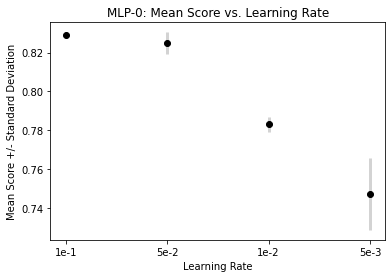

In [ ]:
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

Y = mlp0_means
Y_err = [std*2 for std in mlp0_stds]
plt.clf()
X = ['1e-1', '5e-2', '1e-2', '5e-3']
plt.errorbar(X, Y, yerr=Y_err, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0);
plt.ylabel('Mean Score +/- Standard Deviation')
plt.xlabel('Learning Rate')
plt.title('MLP-0: Mean Score vs. Learning Rate')
plt.show()

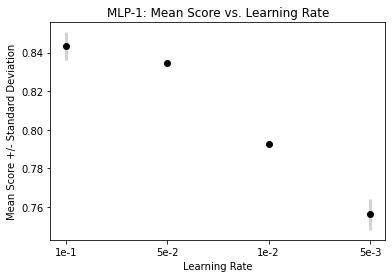

In [ ]:
Y = mlp1_means
Y_err = [std*2 for std in mlp1_stds]
plt.clf()
X = ['1e-1', '5e-2', '1e-2', '5e-3']
plt.errorbar(X, Y, yerr=Y_err, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0);
plt.ylabel('Mean Score +/- Standard Deviation')
plt.xlabel('Learning Rate')
plt.title('MLP-1: Mean Score vs. Learning Rate')
plt.show()

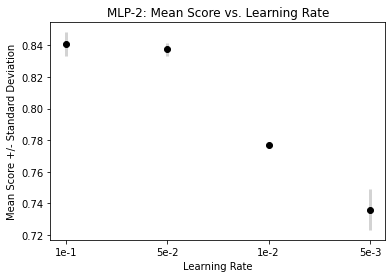

In [ ]:
Y = mlp2_means
Y_err = [std*2 for std in mlp2_stds]
X = ['1e-1', '5e-2', '1e-2', '5e-3']
plt.clf()
plt.errorbar(X, Y, yerr=Y_err, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0);
plt.ylabel('Mean Score +/- Standard Deviation')
plt.xlabel('Learning Rate')
plt.title('MLP-2: Mean Score vs. Learning Rate')
plt.show()

Check Grad

In [ ]:
# mlp_checkg = MLP(activation=ReLU, patience=10, batch_size=2)
# check_train_x, check_test_x, check_test_y, check_test_y = train_test_split(x_train, y_train, train_size=0.001666, test_size=0.001666, random_state=3234)
# mlp_checkg.fit(check_train_x, check_test_y)

In [ ]:
# mlp_checkg.check_g(check_test_x, check_test_y)

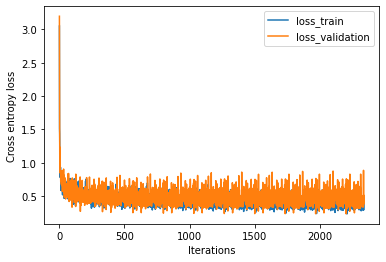

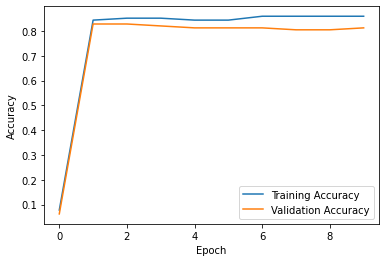

2


In [ ]:
mlp0_ex1 = MLP(iter=10, activation=ReLU, patience=10, batch_size=128, lr=0.1)
mlp0_ex1.fit(x_train, y_train, val=True, acc_plot=True, ce_plot=True)
best_iter = mlp0_ex1.best_iter + 1
print(best_iter)

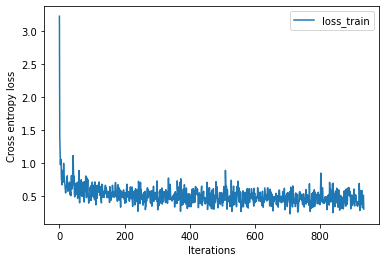

0.8287

In [ ]:
mlp0_ex1 = MLP(iter=best_iter, activation=ReLU, patience=10, batch_size=128, lr=.1)
mlp0_ex1.fit(x_train, y_train, ce_plot=True)
mlp0_ex1_pred = mlp0_ex1.predict(x_test)
evaluate_acc(y_test.argmax(axis=1), mlp0_ex1_pred.argmax(axis=1))

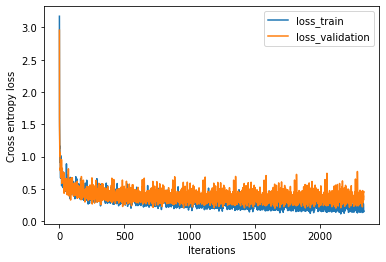

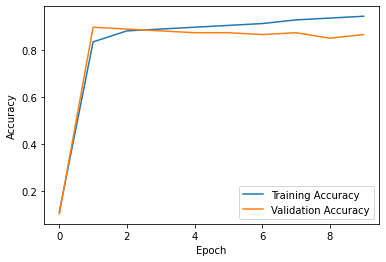

2


In [ ]:
mlp1_ex1 = MLP([128], iter=10, activation=ReLU, patience=10, batch_size=128, lr=0.1)
mlp1_ex1.fit(x_train, y_train, val=True, ce_plot=True, acc_plot=True)
best_iter = mlp1_ex1.best_iter + 1
print(best_iter)

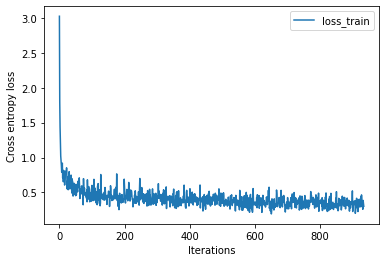

0.8573

In [ ]:
mlp1_ex1 = MLP([128], iter=best_iter, activation=ReLU, patience=10, batch_size=128, lr=.1)
mlp1_ex1.fit(x_train, y_train, ce_plot=True)
mlp1_ex1_pred = mlp1_ex1.predict(x_test)
evaluate_acc(y_test.argmax(axis=1), mlp1_ex1_pred.argmax(axis=1))

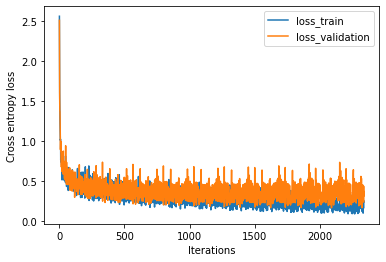

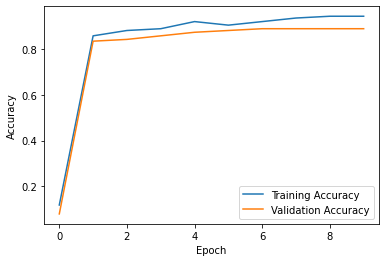

7


In [ ]:
mlp2_ex1 = MLP([128,128], iter=10, activation=ReLU, patience=10, batch_size=128, lr=0.1)
mlp2_ex1.fit(x_train, y_train, val=True, ce_plot=True, acc_plot=True)
best_iter = mlp2_ex1.best_iter + 1
print(best_iter)

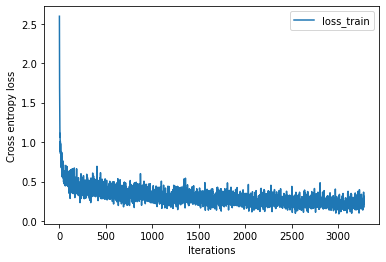

0.8798

In [ ]:
mlp2_ex1 = MLP([128, 128], iter=best_iter, activation=ReLU, patience=10, batch_size=128, lr=.1)
mlp2_ex1.fit(x_train, y_train, ce_plot=True)
mlp2_ex1_pred = mlp2_ex1.predict(x_test)
evaluate_acc(y_test.argmax(axis=1), mlp2_ex1_pred.argmax(axis=1))

##Experiment #2

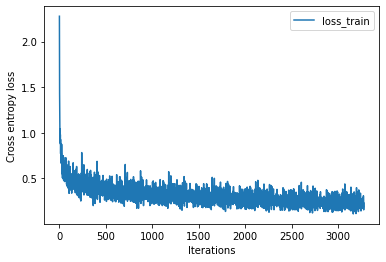

0.8759

In [ ]:
mlp2_tan = MLP([128, 128], iter=best_iter, activation=TanH, patience=10, batch_size=128, lr=.1)
mlp2_tan.fit(x_train, y_train, ce_plot=True)
mlp2_tan_pred = mlp2_tan.predict(x_test)
evaluate_acc(y_test.argmax(axis=1), mlp2_tan_pred.argmax(axis=1))

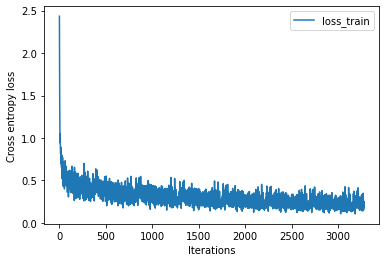

0.881

In [ ]:
mlp2_leaky = MLP([128, 128], iter=best_iter, activation=LeakyReLU, patience=10, batch_size=128, lr=.1)
mlp2_leaky.fit(x_train, y_train, ce_plot=True)
mlp2_leaky_pred = mlp2_leaky.predict(x_test)
evaluate_acc(y_test.argmax(axis=1), mlp2_leaky_pred.argmax(axis=1))

##Experiment #3

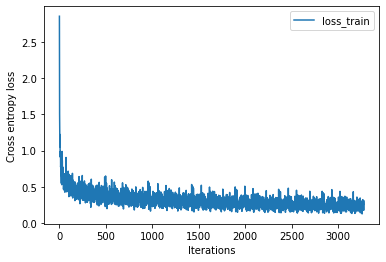

l2 0.001: 0.8742


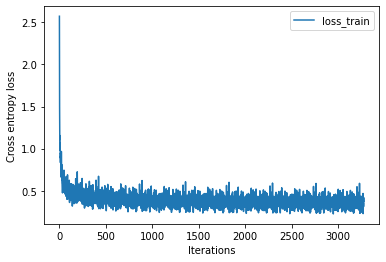

l2 0.01: 0.8587


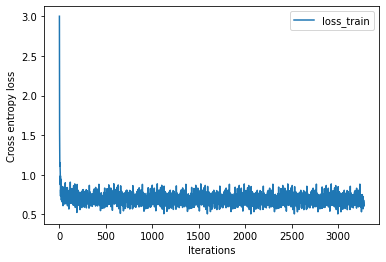

l2 0.1: 0.779


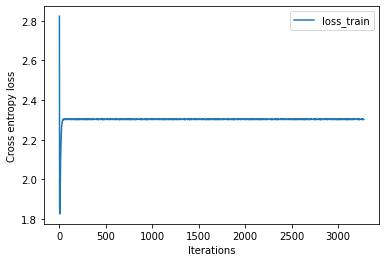

l2 1: 0.1


In [ ]:
for l2 in [0.001, 0.01, 0.1, 1]:
  mlp2_l2 = MLP([128, 128], iter=best_iter, activation=ReLU, patience=10, batch_size=128, lr=.1, l2_reg=l2)
  mlp2_l2.fit(x_train, y_train, ce_plot=True)
  mlp2_l2_pred = mlp2_l2.predict(x_test)
  print(f"l2 {l2}: {evaluate_acc(y_test.argmax(axis=1), mlp2_l2_pred.argmax(axis=1))}")

##Experiment #4

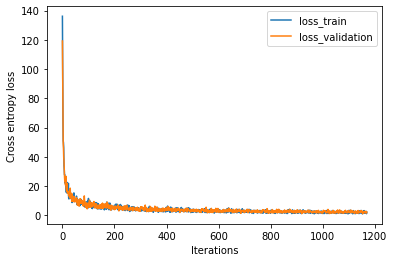

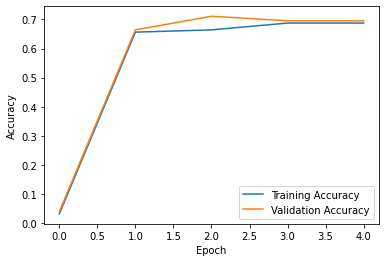

0.3159

In [ ]:
mlp_unnormal = MLP([128, 128], iter=5, activation=ReLU, patience=10, batch_size=128, lr=.0001)
mlp_unnormal.fit(x_unormalized, y_train, val=True, acc_plot=True, ce_plot=True)
mlp_unnormal_pred = mlp_unnormal.predict(x_test)
evaluate_acc(y_test.argmax(axis=1), mlp_unnormal_pred.argmax(axis=1))

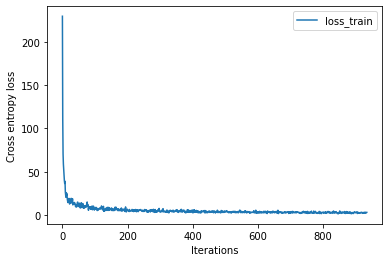

0.7507

In [ ]:
mlp_unnormal = MLP([128, 128], iter=2, activation=ReLU, patience=10, batch_size=128, lr=.0001)
mlp_unnormal.fit(x_unormalized, y_train, ce_plot=True)
mlp_unnormal_pred = mlp_unnormal.predict(x_unormalized_test)
evaluate_acc(y_test.argmax(axis=1), mlp_unnormal_pred.argmax(axis=1))

##Experiment #5

In [5]:
!pip install scikeras 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import keras
import tensorflow
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D, Dropout, MaxPooling2D, Activation, ZeroPadding2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from scikeras.wrappers import KerasClassifier

def create_model(num_filters, filter_size, strides=1, padding='valid', dropout_rate=0):
  model = Sequential()
  model.add(Conv2D(filters = 4 * num_filters,
                 kernel_size = filter_size,
                 strides     = strides,
                 input_shape = (28,28,1),
                 padding     = padding,
                 activation  = 'relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(dropout_rate))
  model.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation="relu"))
  model.add(Dense(128, activation="relu"))
  model.add(Dropout(dropout_rate))
  model.add(Dense(10, activation='softmax')) # output layer  

  model.compile(
  'adam',                             # Optimizer: Adam for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
  )

  return model

# dropout_rate = [0.0, 0.1, 0.5]
num_filters = [2, 4, 8, 16]
filter_size = [3, 6, 9, 12]
# strides = [0, 1]
# padding = ["valid", "same"]


param_grid = dict(model__filter_size=filter_size, model__num_filters = num_filters)


model = KerasClassifier(model=create_model, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_images, train_labels)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.875833 using {'model__filter_size': 3, 'model__num_filters': 8}
0.856750 (0.004532) with: {'model__filter_size': 3, 'model__num_filters': 2}
0.864267 (0.005535) with: {'model__filter_size': 3, 'model__num_filters': 4}
0.875833 (0.004818) with: {'model__filter_size': 3, 'model__num_filters': 8}
0.874417 (0.005517) with: {'model__filter_size': 3, 'model__num_filters': 16}
0.847750 (0.004103) with: {'model__filter_size': 6, 'model__num_filters': 2}
0.858650 (0.003610) with: {'model__filter_size': 6, 'model__num_filters': 4}
0.866767 (0.004327) with: {'model__filter_size': 6, 'model__num_filters': 8}
0.870983 (0.001644) with: {'model__filter_size': 6, 'model__num_filters': 16}
0.843667 (0.000887) with: {'model__filter_size': 9, 'model__num_filters': 2}
0.844350 (0.009162) with: {'model__filter_size': 9, 'model__num_filters': 4}
0.863783 (0.009821) with: {'model__filter_size': 9, 'model__num_filters': 8}
0.872383 (0.004333) with: {'model__filter_size': 9, 'model__num_filters': 16}
n

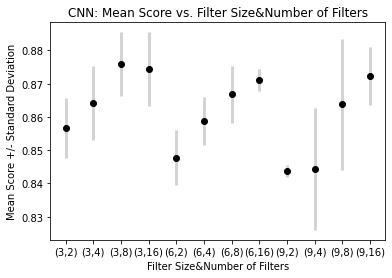

In [14]:
Y = [0.856750, 0.864267, 0.875833, 0.874417, 0.847750,0.858650, 0.866767, 0.870983, 0.843667, 0.844350, 0.863783, 0.872383]
Y_err = [0.004532*2, 0.005535*2, 0.004818*2,0.005517*2,0.004103*2, 0.003610*2,0.004327*2,0.001644*2,0.000887*2,0.009162*2,0.009821*2,0.004333*2]
X = ['(3,2)', '(3,4)', '(3,8)','(3,16)', '(6,2)', '(6,4)', '(6,8)','(6,16)','(9,2)','(9,4)', '(9,8)', '(9,16)' ]
plt.clf()
plt.errorbar(X, Y, yerr=Y_err, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0);
plt.ylabel('Mean Score +/- Standard Deviation')
plt.xlabel('Filter Size&Number of Filters')
plt.title('CNN: Mean Score vs. Filter Size&Number of Filters')
plt.show()

In [6]:
import keras
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D, Dropout, MaxPooling2D, Activation, ZeroPadding2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from scikeras.wrappers import KerasClassifier


def create_model(num_filters=8, filter_size=3, strides=1, padding='valid', dropout_rate=0):
  model = Sequential()
  model.add(Conv2D(filters = 4 * num_filters,
                 kernel_size = filter_size,
                 strides     = strides,
                 input_shape = (28,28,1),
                 padding     = padding,
                 activation  = 'relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(dropout_rate))
  model.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation="relu"))
  model.add(Dense(128, activation="relu"))
  model.add(Dropout(dropout_rate))
  model.add(Dense(10, activation='softmax')) # output layer  

  model.compile(
  'adam',                             # Optimizer: Adam for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
  )

  return model

In [8]:
from sklearn.model_selection import GridSearchCV
X = np.expand_dims(train_images, axis=3)
X_test = np.expand_dims(test_images, axis=3)

dropout_rate = [0.0, 0.1, 0.5]
param_grid = dict(model__dropout_rate=dropout_rate)
model = KerasClassifier(model=create_model, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_images, train_labels)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.872967 using {'model__dropout_rate': 0.0}
0.872967 (0.002252) with: {'model__dropout_rate': 0.0}
0.871983 (0.001595) with: {'model__dropout_rate': 0.1}
0.853767 (0.002911) with: {'model__dropout_rate': 0.5}


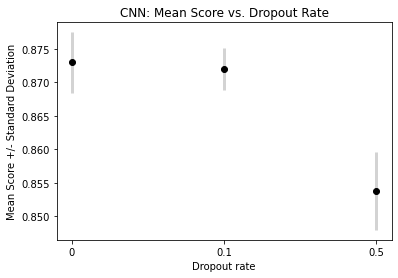

In [15]:
Y = means
Y_err = [std*2 for std in stds]
X = [ '0', '0.1', '0.5']
plt.clf()
plt.errorbar(X, Y, yerr=Y_err, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0);
plt.ylabel('Mean Score +/- Standard Deviation')
plt.xlabel('Dropout rate')
plt.title('CNN: Mean Score vs. Dropout Rate')
plt.show()

In [9]:
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
model = Sequential()
model.add(Conv2D(filters = 4 * 8,
                kernel_size = 3,
                strides     = 1,
                input_shape = (28,28,1),
                padding     = 'valid',
                activation  = 'relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0))
model.add(Conv2D(filters = 8 * 8, kernel_size = (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0))
model.add(Dense(10, activation='softmax')) # output layer  

model.compile(
'adam',                             # Optimizer: Adam for gradient descent-based: https://keras.io/api/optimizers/
loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)
model_history = model.fit(train_images, train_labels, validation_split=0.33, epochs=15)

Epoch 1/15
1257/1257 [==============================] - 7s 5ms/step - loss: 0.4822 - accuracy: 0.8226 - val_loss: 0.3576 - val_accuracy: 0.8675
Epoch 2/15
1257/1257 [==============================] - 6s 5ms/step - loss: 0.3130 - accuracy: 0.8854 - val_loss: 0.3059 - val_accuracy: 0.8882
Epoch 3/15
1257/1257 [==============================] - 7s 6ms/step - loss: 0.2575 - accuracy: 0.9044 - val_loss: 0.2876 - val_accuracy: 0.8962
Epoch 4/15
1257/1257 [==============================] - 6s 5ms/step - loss: 0.2231 - accuracy: 0.9151 - val_loss: 0.3041 - val_accuracy: 0.8895
Epoch 5/15
1257/1257 [==============================] - 7s 5ms/step - loss: 0.1910 - accuracy: 0.9287 - val_loss: 0.2799 - val_accuracy: 0.9064
Epoch 6/15
1257/1257 [==============================] - 7s 6ms/step - loss: 0.1675 - accuracy: 0.9368 - val_loss: 0.2856 - val_accuracy: 0.9045
Epoch 7/15
1257/1257 [==============================] - 8s 6ms/step - loss: 0.1392 - accuracy: 0.9472 - val_loss: 0.3155 - val_accuracy:

In [ ]:
model_history.history

{'loss': [0.7155491709709167,
  0.339069128036499,
  0.3049178123474121,
  0.2827325761318207,
  0.26471343636512756],
 'accuracy': [0.8242990970611572,
  0.8764148354530334,
  0.8884549140930176,
  0.8968382477760315,
  0.9024602770805359],
 'val_loss': [0.40457555651664734,
  0.3403635621070862,
  0.34478136897087097,
  0.3650030791759491,
  0.363182008266449],
 'val_accuracy': [0.8541992902755737,
  0.8770769238471985,
  0.878137469291687,
  0.8776829242706299,
  0.8789960145950317]}

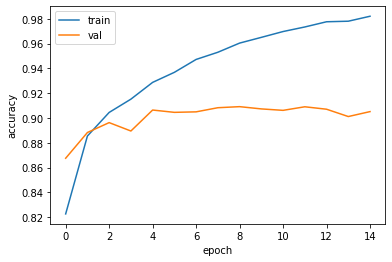

In [10]:
plt.clf()
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [11]:
model = Sequential()
model.add(Conv2D(filters = 4 * 16,
                kernel_size = 3,
                strides     = 1,
                input_shape = (28,28,1),
                padding     = 'valid',
                activation  = 'relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0))
model.add(Conv2D(filters = 8 * 16, kernel_size = (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0))
model.add(Dense(10, activation='softmax')) # output layer  

model.compile(
'adam',                             # Optimizer: Adam for gradient descent-based: https://keras.io/api/optimizers/
loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)
model_history = model.fit(train_images, train_labels, epochs=9)

Epoch 1/9
1875/1875 [==============================] - 7s 3ms/step - loss: 0.4185 - accuracy: 0.8469
Epoch 2/9
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2728 - accuracy: 0.8995
Epoch 3/9
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2257 - accuracy: 0.9173
Epoch 4/9
1875/1875 [==============================] - 7s 3ms/step - loss: 0.1898 - accuracy: 0.9284
Epoch 5/9
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1616 - accuracy: 0.9400
Epoch 6/9
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1374 - accuracy: 0.9484
Epoch 7/9
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1174 - accuracy: 0.9564
Epoch 8/9
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0986 - accuracy: 0.9628
Epoch 9/9
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0862 - accuracy: 0.9678


313/313 [==============================] - 1s 2ms/step
Test accuracy: 91.4%
Test error: 8.6%


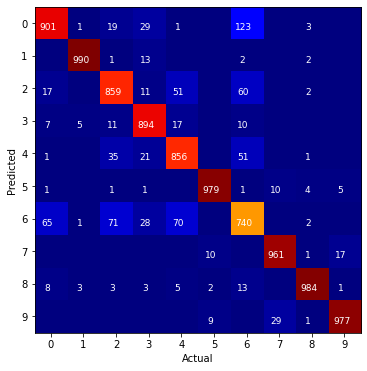

In [12]:
def calc_error(predictions, labels):
    """Return the error rate and confusions."""
    correct = np.sum(predictions == labels)
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = np.zeros([10, 10], np.float32)
    bundled = zip(predictions, labels)
    for predicted, actual in bundled:
        confusions[predicted, actual] += 1
    
    return error, confusions
test_predictions          = np.argmax(model.predict(test_images),1)
test_error, test_conf_mat = calc_error(test_predictions, np.argmax(test_labels,1))
test_acc = 100.0 - test_error
print('Test accuracy: %.1f%%' % test_acc)
print('Test error: %.1f%%' % test_error)

plt.figure(figsize=(6, 6))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.imshow(test_conf_mat, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(test_conf_mat):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')

In [16]:
model.evaluate(test_images, test_labels)

313/313 [==============================] - 2s 4ms/step - loss: 0.3506 - accuracy: 0.9141


[0.3505955636501312, 0.9140999913215637]

##Experiment #6

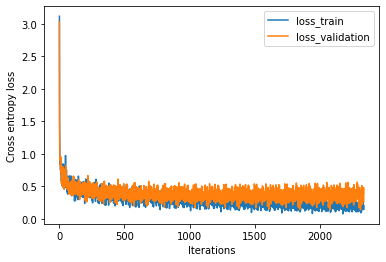

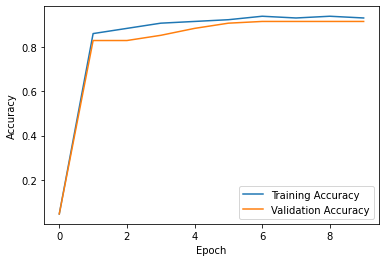

7


In [30]:
mlp256 = MLP([256], iter=10, activation=LeakyReLU, patience=10, batch_size=128, lr=0.1)
mlp256.fit(x_train, y_train, val=True, ce_plot=True, acc_plot=True)
best_iter = mlp256.best_iter + 1
print(best_iter)

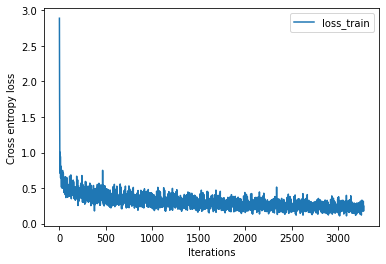

0.876

In [31]:
mlp256 = MLP([256], iter=best_iter, activation=LeakyReLU, patience=10, batch_size=128, lr=.1)
mlp256.fit(x_train, y_train, ce_plot=True)
mlp256_pred = mlp256.predict(x_test)
evaluate_acc(y_test.argmax(axis=1), mlp256_pred.argmax(axis=1))

In [ ]:
mlp2_32 = MLP([32,32], iter = 7, activation=ReLU, patience=10, batch_size=128, lr=.1 )
mlp2_32.fit(x_train, y_train, ce_plot=True)
mlp2_32_pred = mlp2_32.predict(x_test)
evaluate_acc(y_test.argmax(axis=1), mlp2_32_pred.argmax(axis=1))

In [ ]:
mlp2_64 = MLP([64,64], iter = 7, activation=ReLU, patience=10, batch_size=128, lr=.1 )
mlp2_64.fit(x_train, y_train, ce_plot=True)
mlp2_64_pred = mlp2_64.predict(x_test)
evaluate_acc(y_test.argmax(axis=1), mlp2_64_pred.argmax(axis=1))

In [ ]:
mlp2_256 = MLP([256,256], iter = 7, activation=ReLU, patience=10, batch_size=128, lr=.1 )
mlp2_256.fit(x_train, y_train, ce_plot=True)
mlp2_256_pred = mlp2_256.predict(x_test)
evaluate_acc(y_test.argmax(axis=1), mlp2_256_pred.argmax(axis=1))

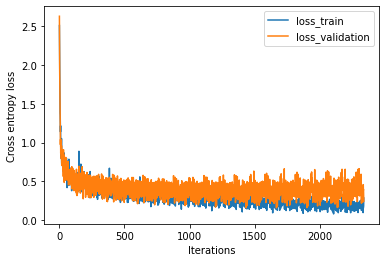

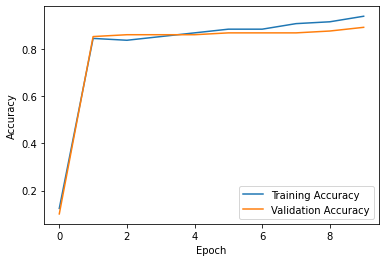

10


In [ ]:
mlp2_ex6 = MLP([128,128,128], iter=10, activation=LeakyReLU, patience=10, batch_size=128, lr=0.1)
mlp2_ex6.fit(x_train, y_train, val=True, ce_plot=True, acc_plot=True)
best_iter = mlp2_ex6.best_iter + 1
print(best_iter)

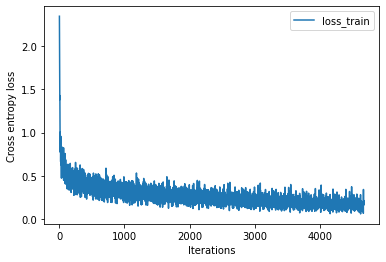

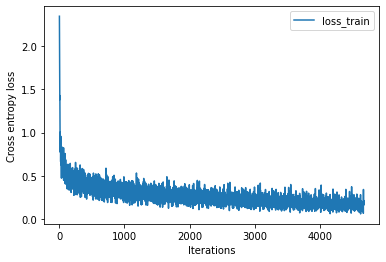

0.8822

0.8822

In [14]:
mlp2_leaky = MLP([128, 128, 128], iter=10, activation=LeakyReLU, patience=10, batch_size=128, lr=.1)
mlp2_leaky.fit(x_train, y_train, ce_plot=True)
mlp2_leaky_pred = mlp2_leaky.predict(x_test)
evaluate_acc(y_test.argmax(axis=1), mlp2_leaky_pred.argmax(axis=1))

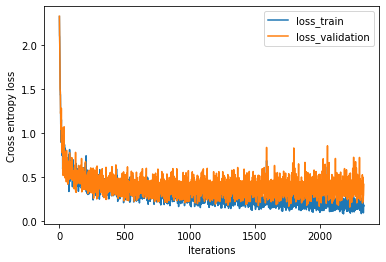

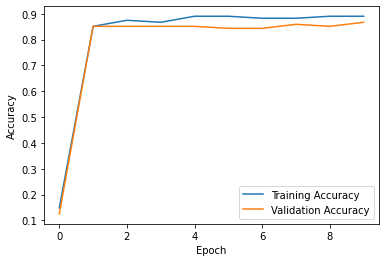

10


In [15]:
mlp4 = MLP([128,128,128,128], iter=10, activation=LeakyReLU, patience=10, batch_size=128, lr=0.1)
mlp4.fit(x_train, y_train, val=True, ce_plot=True, acc_plot=True)
best_iter = mlp4.best_iter + 1
print(best_iter)

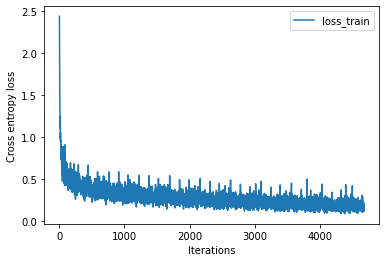

0.8746

In [17]:
mlp4_leaky = MLP([128, 128, 128,128], iter=10, activation=LeakyReLU, patience=10, batch_size=128, lr=.1)
mlp4_leaky.fit(x_train, y_train, ce_plot=True)
mlp4_leaky_pred = mlp4_leaky.predict(x_test)
evaluate_acc(y_test.argmax(axis=1), mlp4_leaky_pred.argmax(axis=1))

##Small Perturbation

In [34]:
mlp_check = MLP(activation=ReLU, patience=10, batch_size=128)
#mlp_check.fit(x_train[:129,:], y_train[:129,:])
#mlp_check.layers[0].gradient[0].mean(axis=0).shape

In [41]:
y_train[:1,:].shape

(1, 10)

In [35]:
ret = mlp_check.check_g(x_train[:200], y_train[:200])

print(ret)

[1.4468266349237225e-11]
